# 예측 애널리틱스: 정규화모델 실습

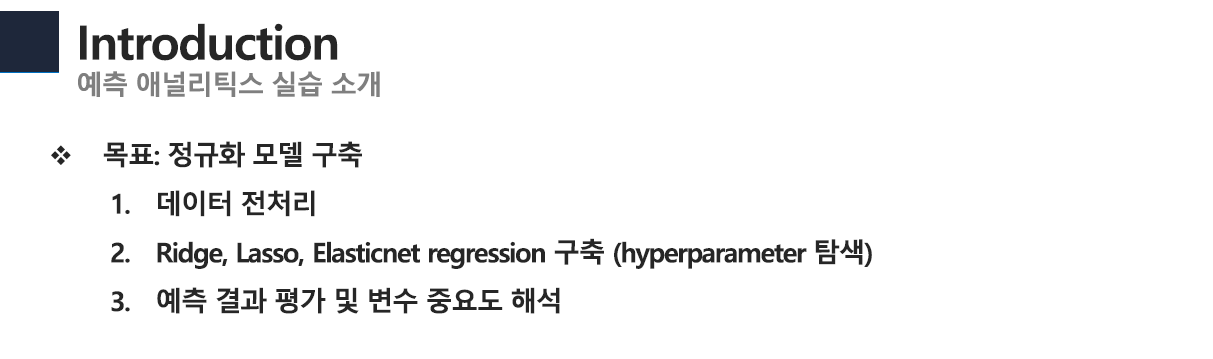

이지윤 / jiyoonlee@korea.ac.kr

## 1. 모듈 불러오기

In [ ]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 전처리
import numpy as np
import pandas as pd

# 기계학습 모델 및 평가
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 2. 데이터 불러오기: HousePrices

#### 데이터 구조
- 데이터: 집 가격 예측 데이터
- 관측치 개수: 1460개
- 변수 개수: 80개 (집의 특성, 집가격)

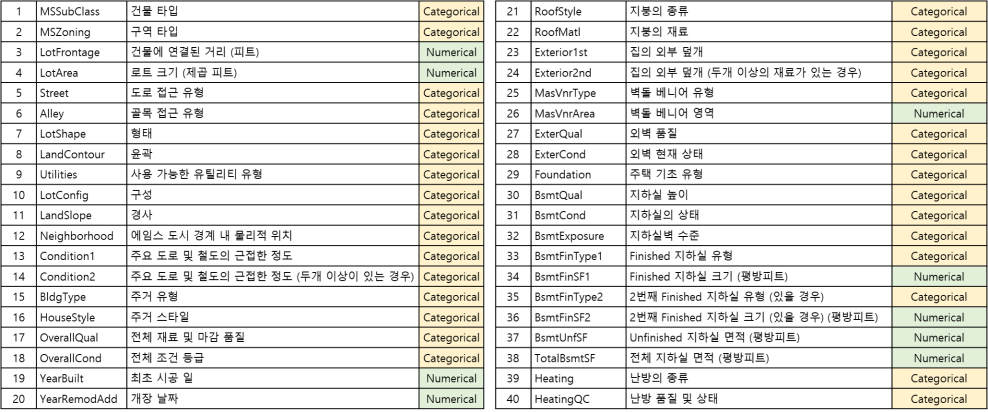

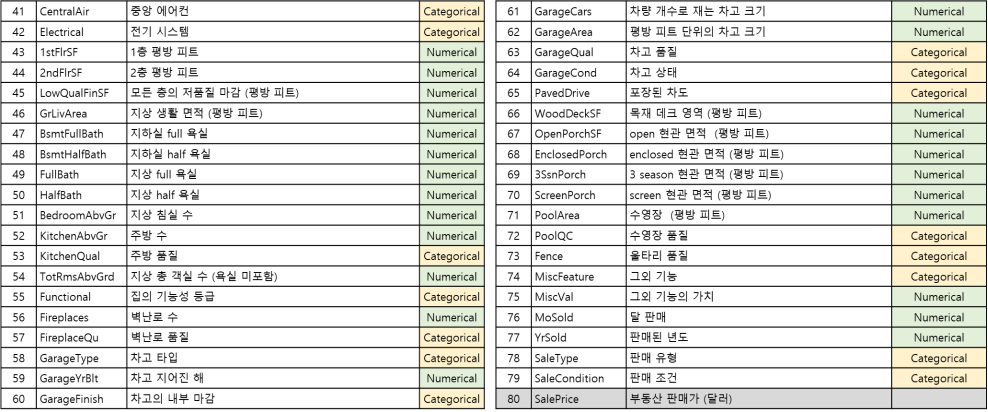

In [ ]:
data = pd.read_csv('Data/HousePrices.csv',index_col='Id')
data.head()

## 3. 탐색적 데이터 분석 및 데이터 전처리

### 데이터 shape 확인

In [ ]:
print(f'관측치 수 : {data.shape[0]} \n변수 수 : {data.shape[1]}')

### 결측치, 데이터 타입 확인

In [ ]:
data.info()

In [ ]:
data.describe()

### 데이터 타입 변환 (int -> str(object))

In [ ]:
for categ in ['MSSubClass', 'OverallQual', 'OverallCond']:
    data[categ] = data[categ].astype(str)

### target y 값 분포 확인 

In [ ]:
f = sns.distplot(data['SalePrice'])

### Train/Test 데이터 분리
- 설명변수(X), 반응변수(y) 나누기

In [ ]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

display(X.head(3))

- Training 데이터 70% / Testing 데이터 30% 나누기

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2021)

### Null 확인 및 대체
- Null, NaN, NA, '정해지지 않은 값' 개수 확인
- https://data-make.tistory.com/120

In [ ]:
NaNinfo = X_train.isnull().sum()
NaNinfo = NaNinfo.sort_values(ascending=False) # 내림차순 정렬
NaNinfo = NaNinfo[NaNinfo > 0]
NaNinfo

In [ ]:
# unique names for features with NaN values
for col in NaNinfo.index:
    print(f'{col} : {data[col].unique().tolist()[:10]}')

- Target : SalePrice에 결측값이 있다면 해당 관측치는 제거
- Numerical : 평균값으로 대체 (다양한 방법이 있을 수 있으나)
- Categorical : 'NaN'으로 대체

In [ ]:
for feature in ['LotFrontage', 'LotArea', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath', 'HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                'ScreenPorch', 'PoolArea','MiscVal']:
    X_train[feature] = X_train[feature].fillna(X_train[feature].mean())
    X_test[feature] = X_test[feature].fillna(X_train[feature].mean())
    
for feature in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual',
                'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
                'Electrical', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual',
                'SaleType', 'Exterior1st', 'Exterior2nd','MasVnrType']:
    X_train[feature] = X_train[feature].fillna('NaN')
    X_test[feature] = X_test[feature].fillna('NaN')

- data 타입별로 변수명 묶기
- 카테고리 변수명만 뽑아내기

In [ ]:
category = list(X_train.select_dtypes(include=[object]))
category[:10]

- 카테고리 변수 encoding (vectorizing)
- 수치형 변수 scaling
- 주의점 : train 학습 데이터로 encoding, scaler fitting

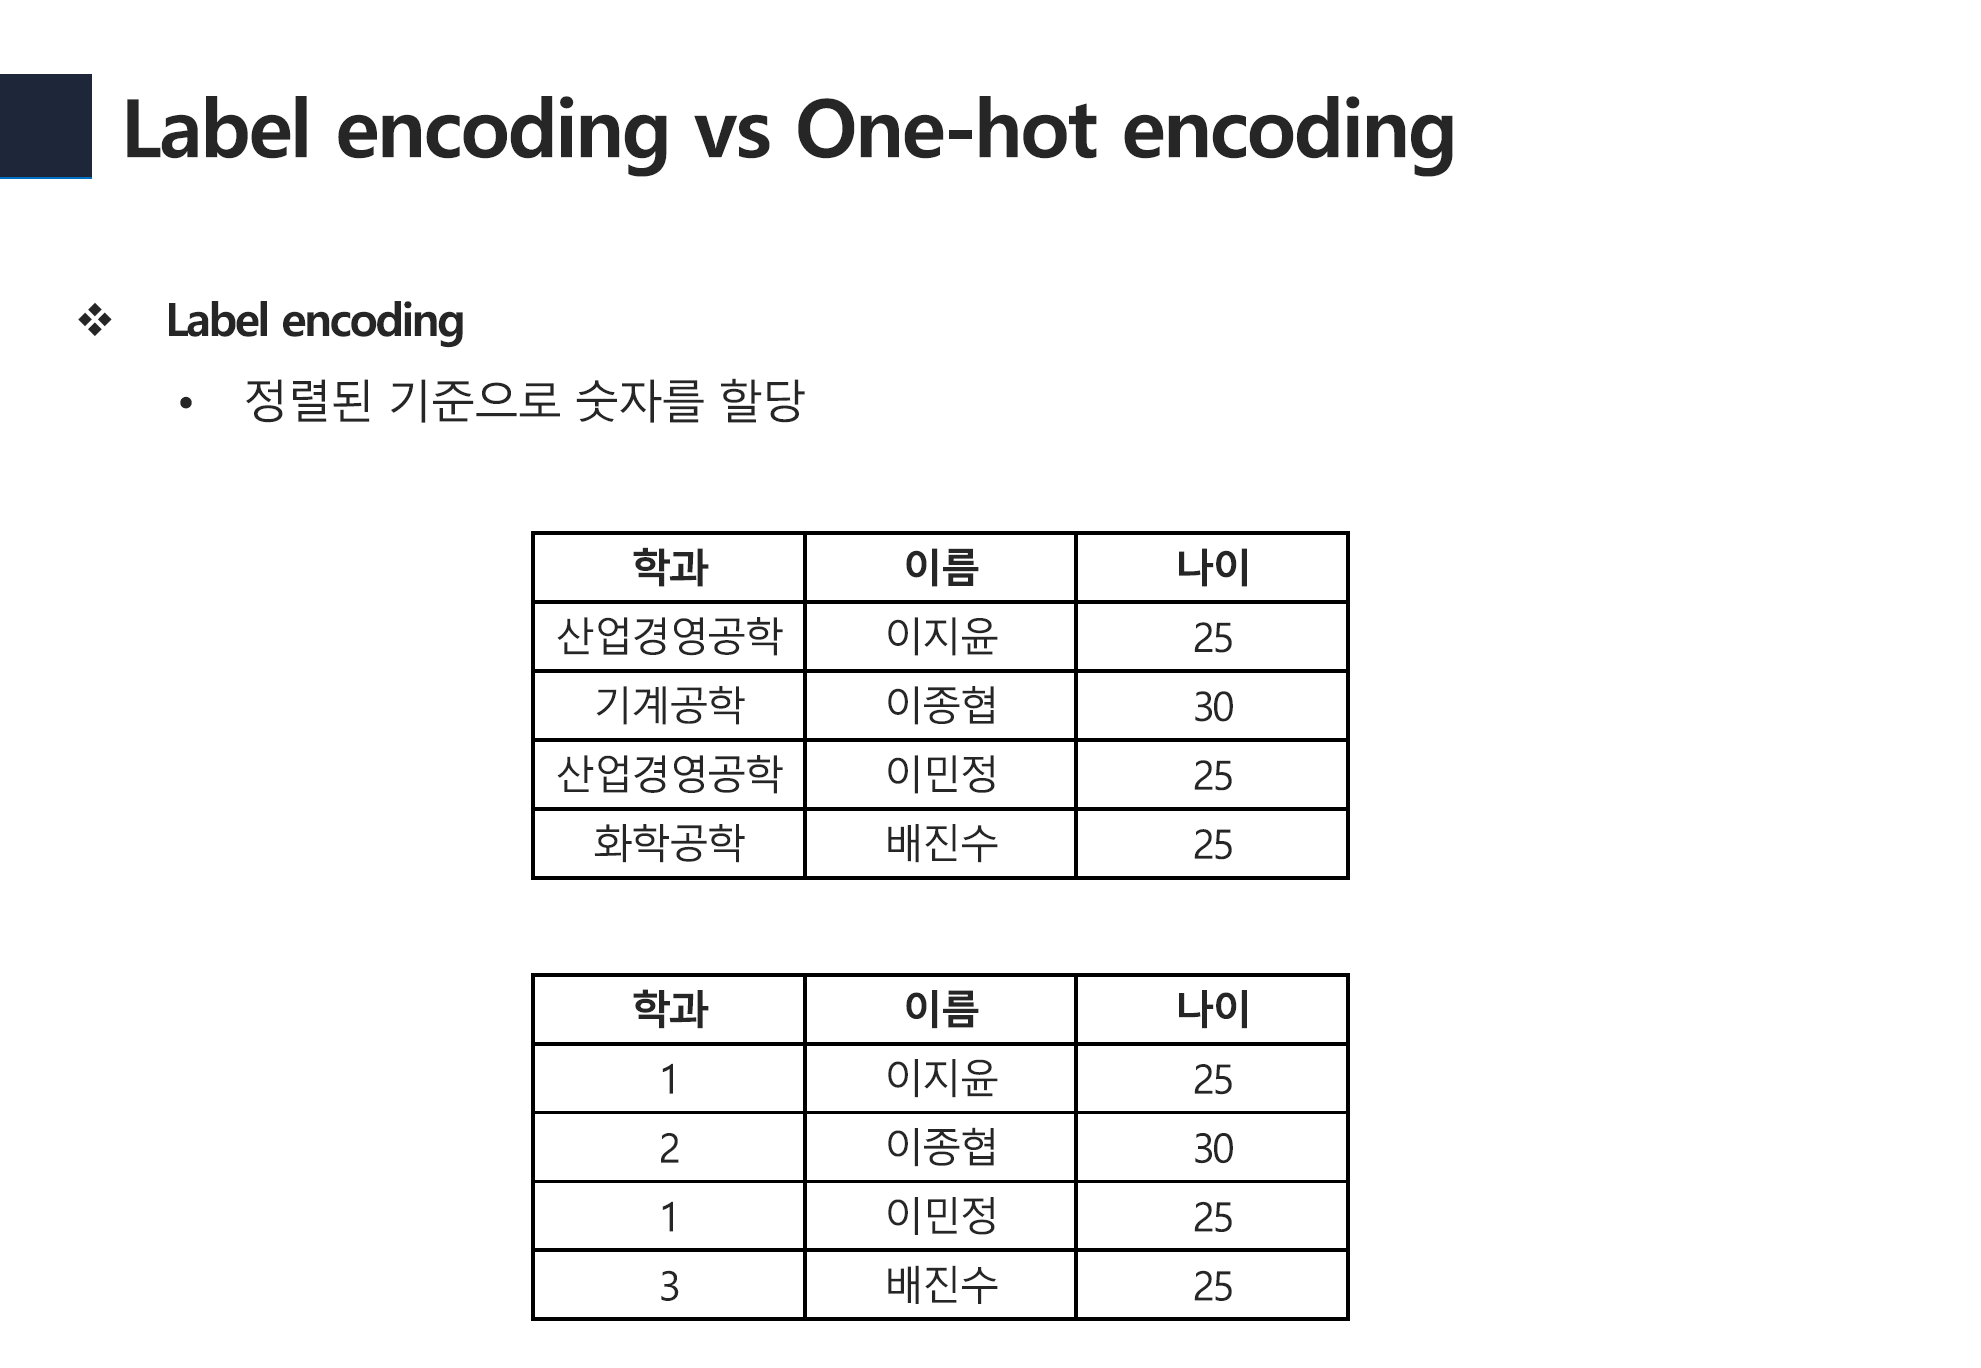

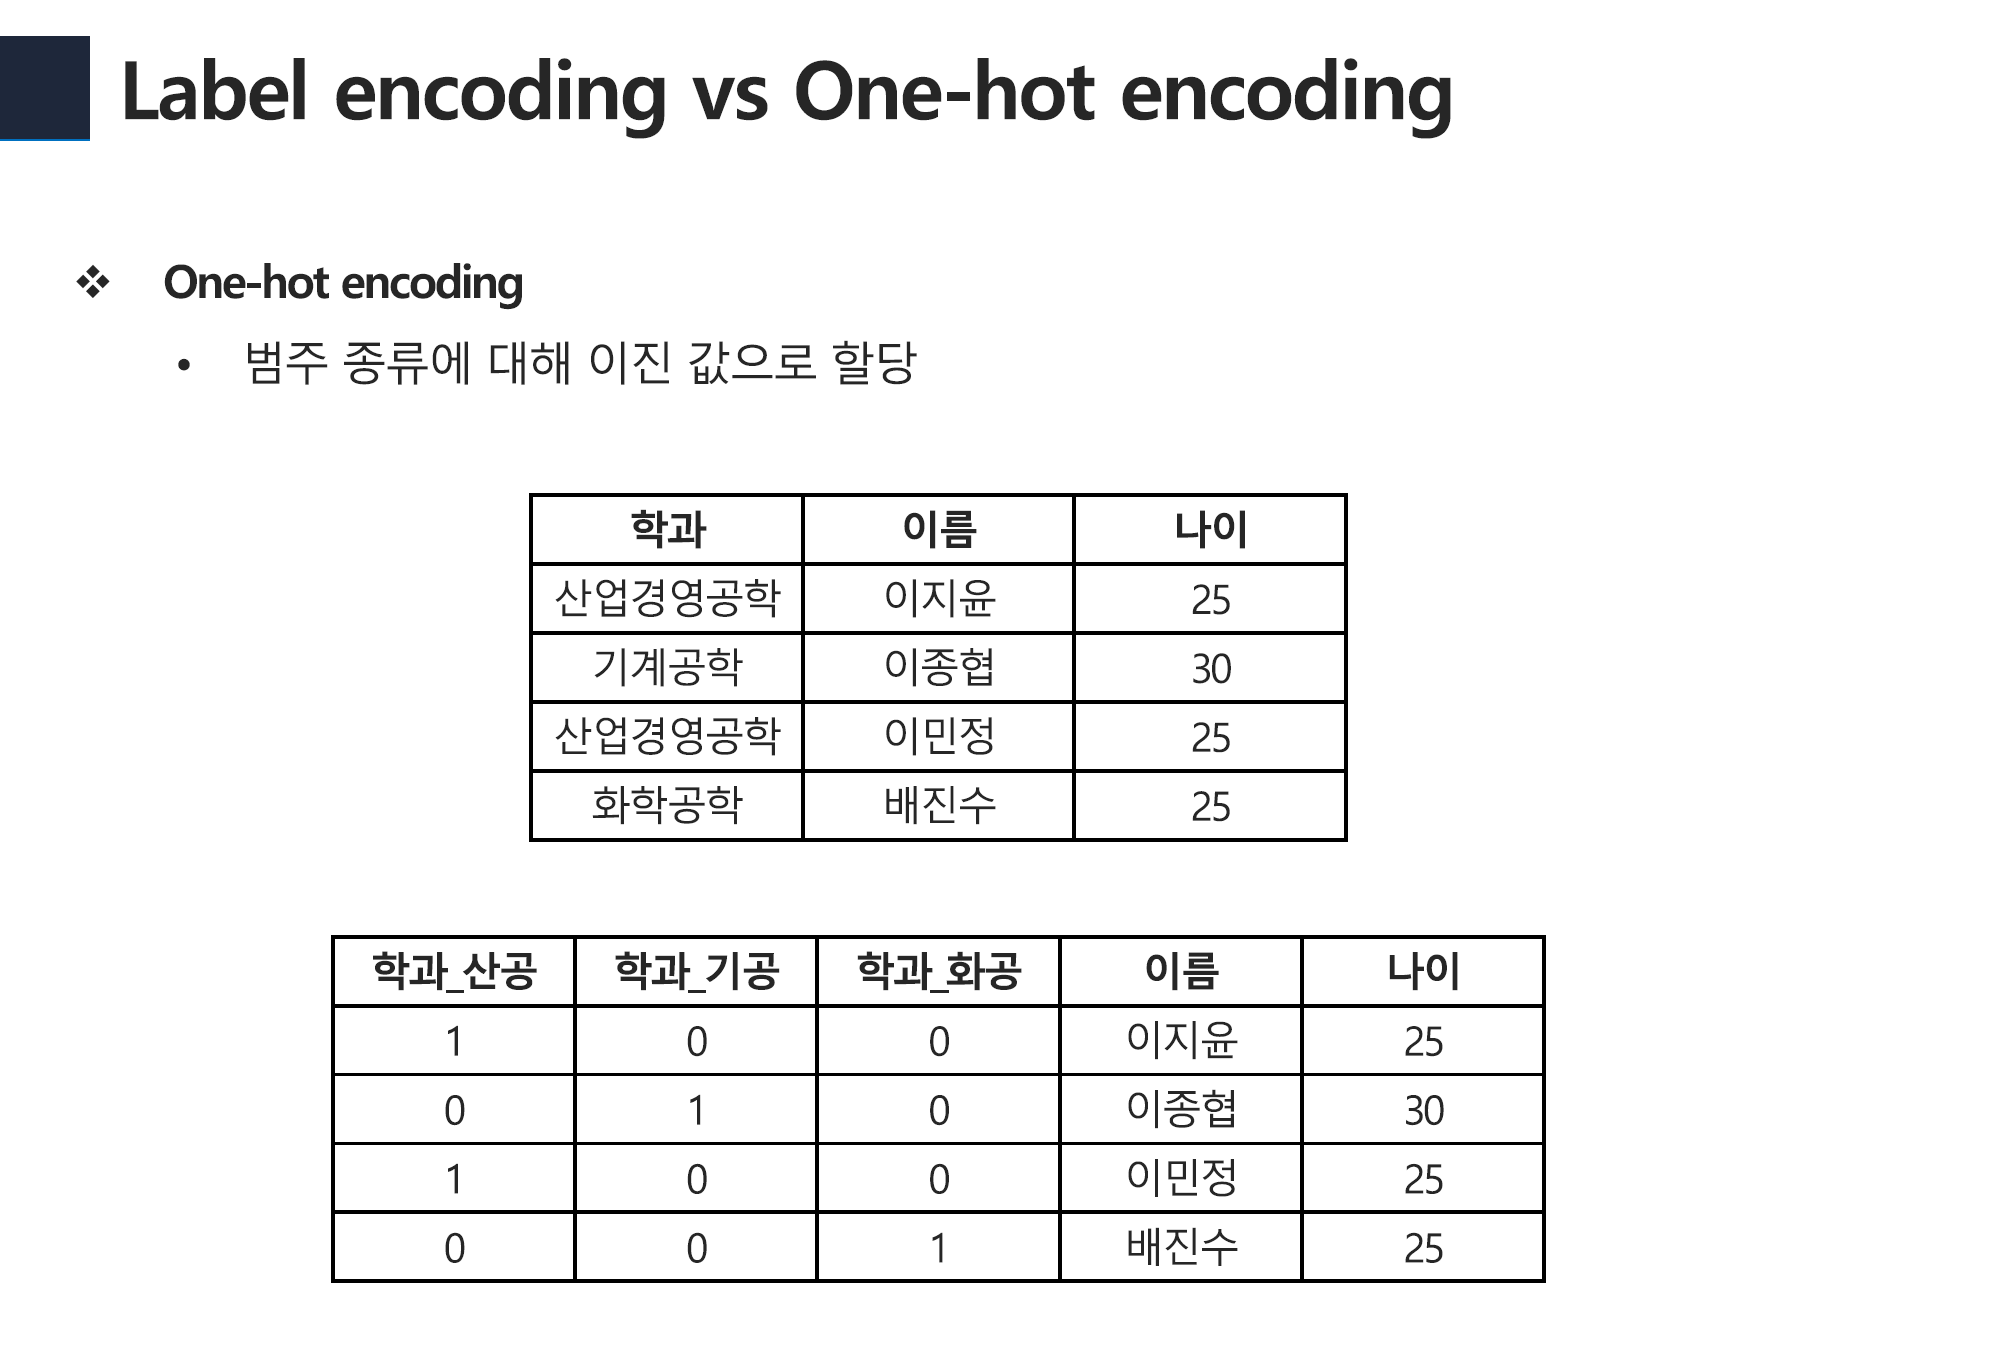

In [ ]:
#whole_data = pd.concat([X_train, X_test], axis=0)
vec = DictVectorizer()
vec.fit(X_train[category].to_dict('records'))

scaler = StandardScaler()
scaler.fit(X_train.drop(category, axis=1))

In [ ]:
X_category = vec.transform(X_train[category].to_dict('records'))
X_train_category = pd.DataFrame(X_category.toarray(), columns=vec.feature_names_)
display(X_train_category.head())

X_train_without_category = X_train.drop(category, axis=1)
X_scale = scaler.transform(X_train_without_category)
X_train_scale = pd.DataFrame(X_scale, columns=X_train_without_category.columns)
display(X_train_scale.head())

In [ ]:
X_train_final = pd.concat([X_train_scale, X_train_category], axis=1)
X_train_final.tail()

In [ ]:
X_category = vec.transform(X_test[category].to_dict('records'))
X_test_category = pd.DataFrame(X_category.toarray(), columns=vec.feature_names_)
display(X_test_category.head())

X_test_without_category = X_test.drop(category, axis=1)
X_scale = scaler.transform(X_test_without_category)
X_test_scale = pd.DataFrame(X_scale, columns=X_test_without_category.columns)
display(X_test_scale.head())

In [ ]:
X_test_final = pd.concat([X_test_scale, X_test_category], axis=1)
X_test_final.tail()

In [ ]:
X_train, y_train = X_train_final.values, y_train.values
X_test, y_test = X_test_final.values, y_test.values

## 3. 모델링
- sklearn.linear_model
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
- Lasso, Ridge, ElasticNet

### 3.1 Linear regression vs Lasso vs Ridge 계수 비교

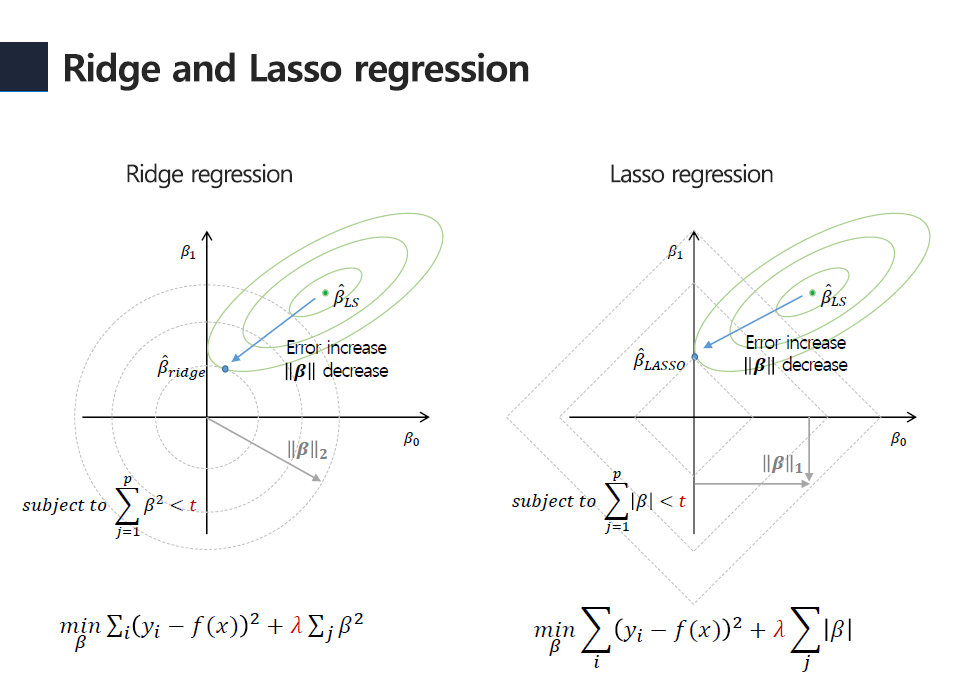

In [ ]:
model_LR = LinearRegression(n_jobs=-1)
model_LR.fit(X_train, y_train)
display(pd.DataFrame(model_LR.coef_,
                     index=X_test_final.columns, columns=['Linear regression 계수']))

In [ ]:
model_Lasso1 = Lasso(alpha=0.0001,random_state=1)
model_Lasso2 = Lasso(alpha=100.0,random_state=1)
model_Ridge1 = Ridge(alpha=0.0001, random_state=1)
model_Ridge2 = Ridge(alpha=100.0, random_state=1)

model_Lasso1.fit(X_train, y_train)
model_Lasso2.fit(X_train, y_train)
model_Ridge1.fit(X_train, y_train)
model_Ridge2.fit(X_train, y_train)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(sorted(np.abs(model_LR.coef_))[::-1], label='LR', c='gray')
plt.plot(sorted(np.abs(model_Lasso1.coef_))[::-1], label='Lasso alpha=0.0001')
plt.plot(sorted(np.abs(model_Lasso2.coef_))[::-1], label='Lasso alpha=100')
plt.plot(sorted(np.abs(model_Ridge1.coef_))[::-1], label='Ridge alpha=0.0001')
plt.plot(sorted(np.abs(model_Ridge2.coef_))[::-1], label='Ridge alpha=100')
plt.legend()
plt.ylim((-0.1,1000)) # 50000
plt.show()

### 3.2 k fold cross validation으로 하이퍼파라미터(lambda=alpha) 찾기

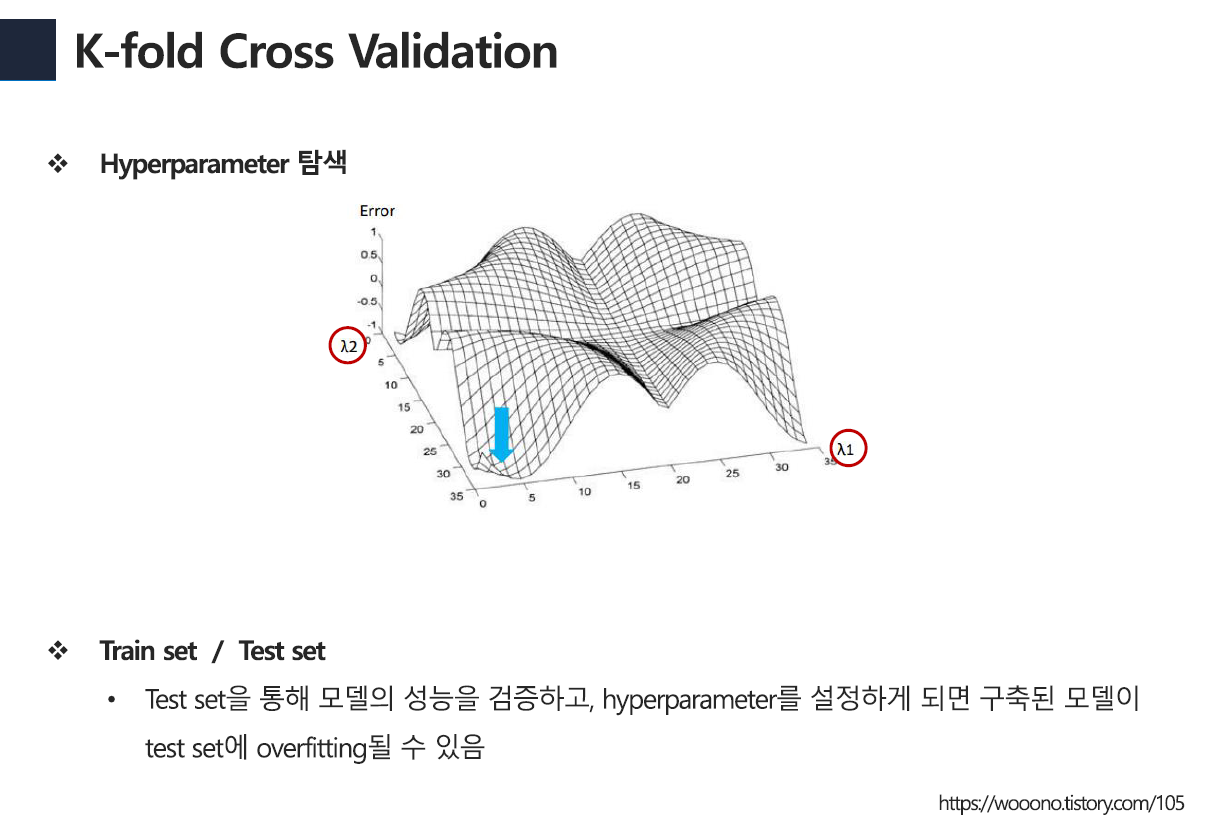

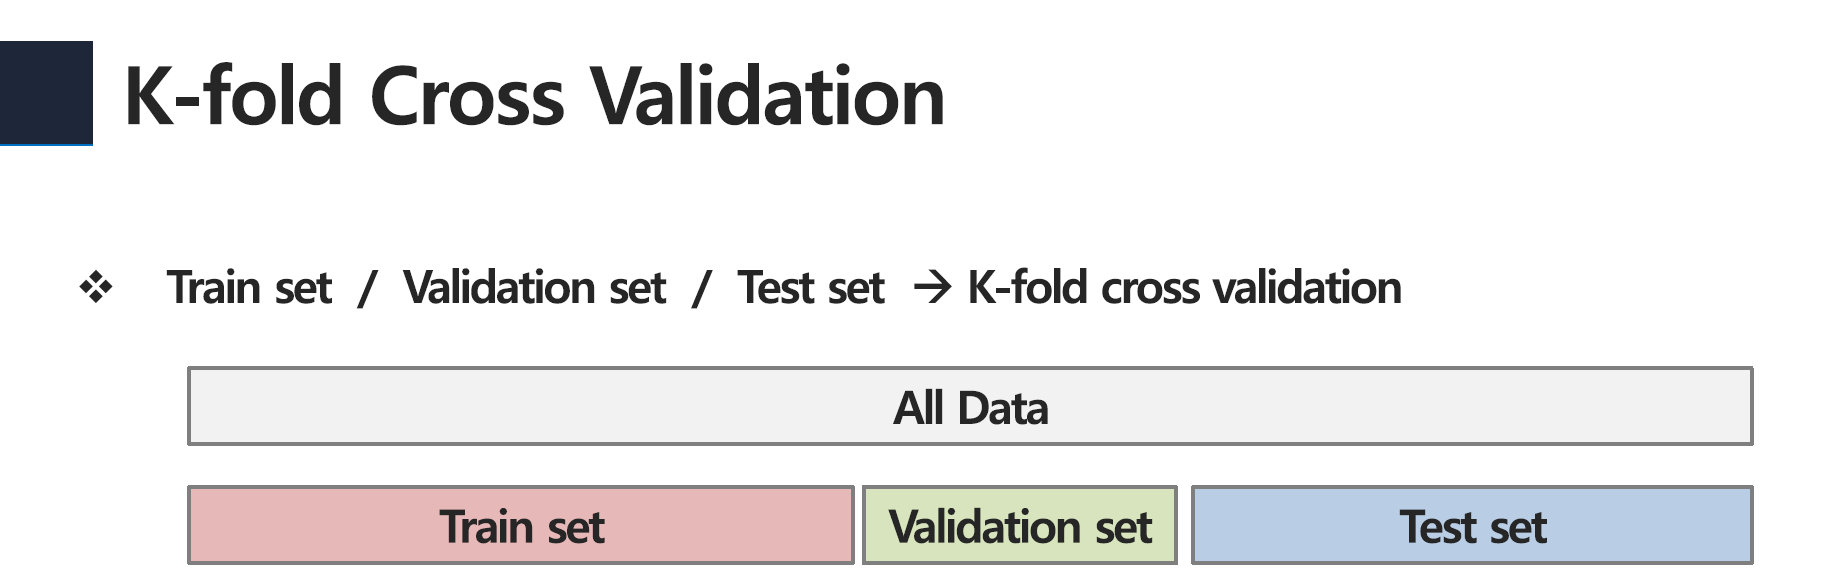

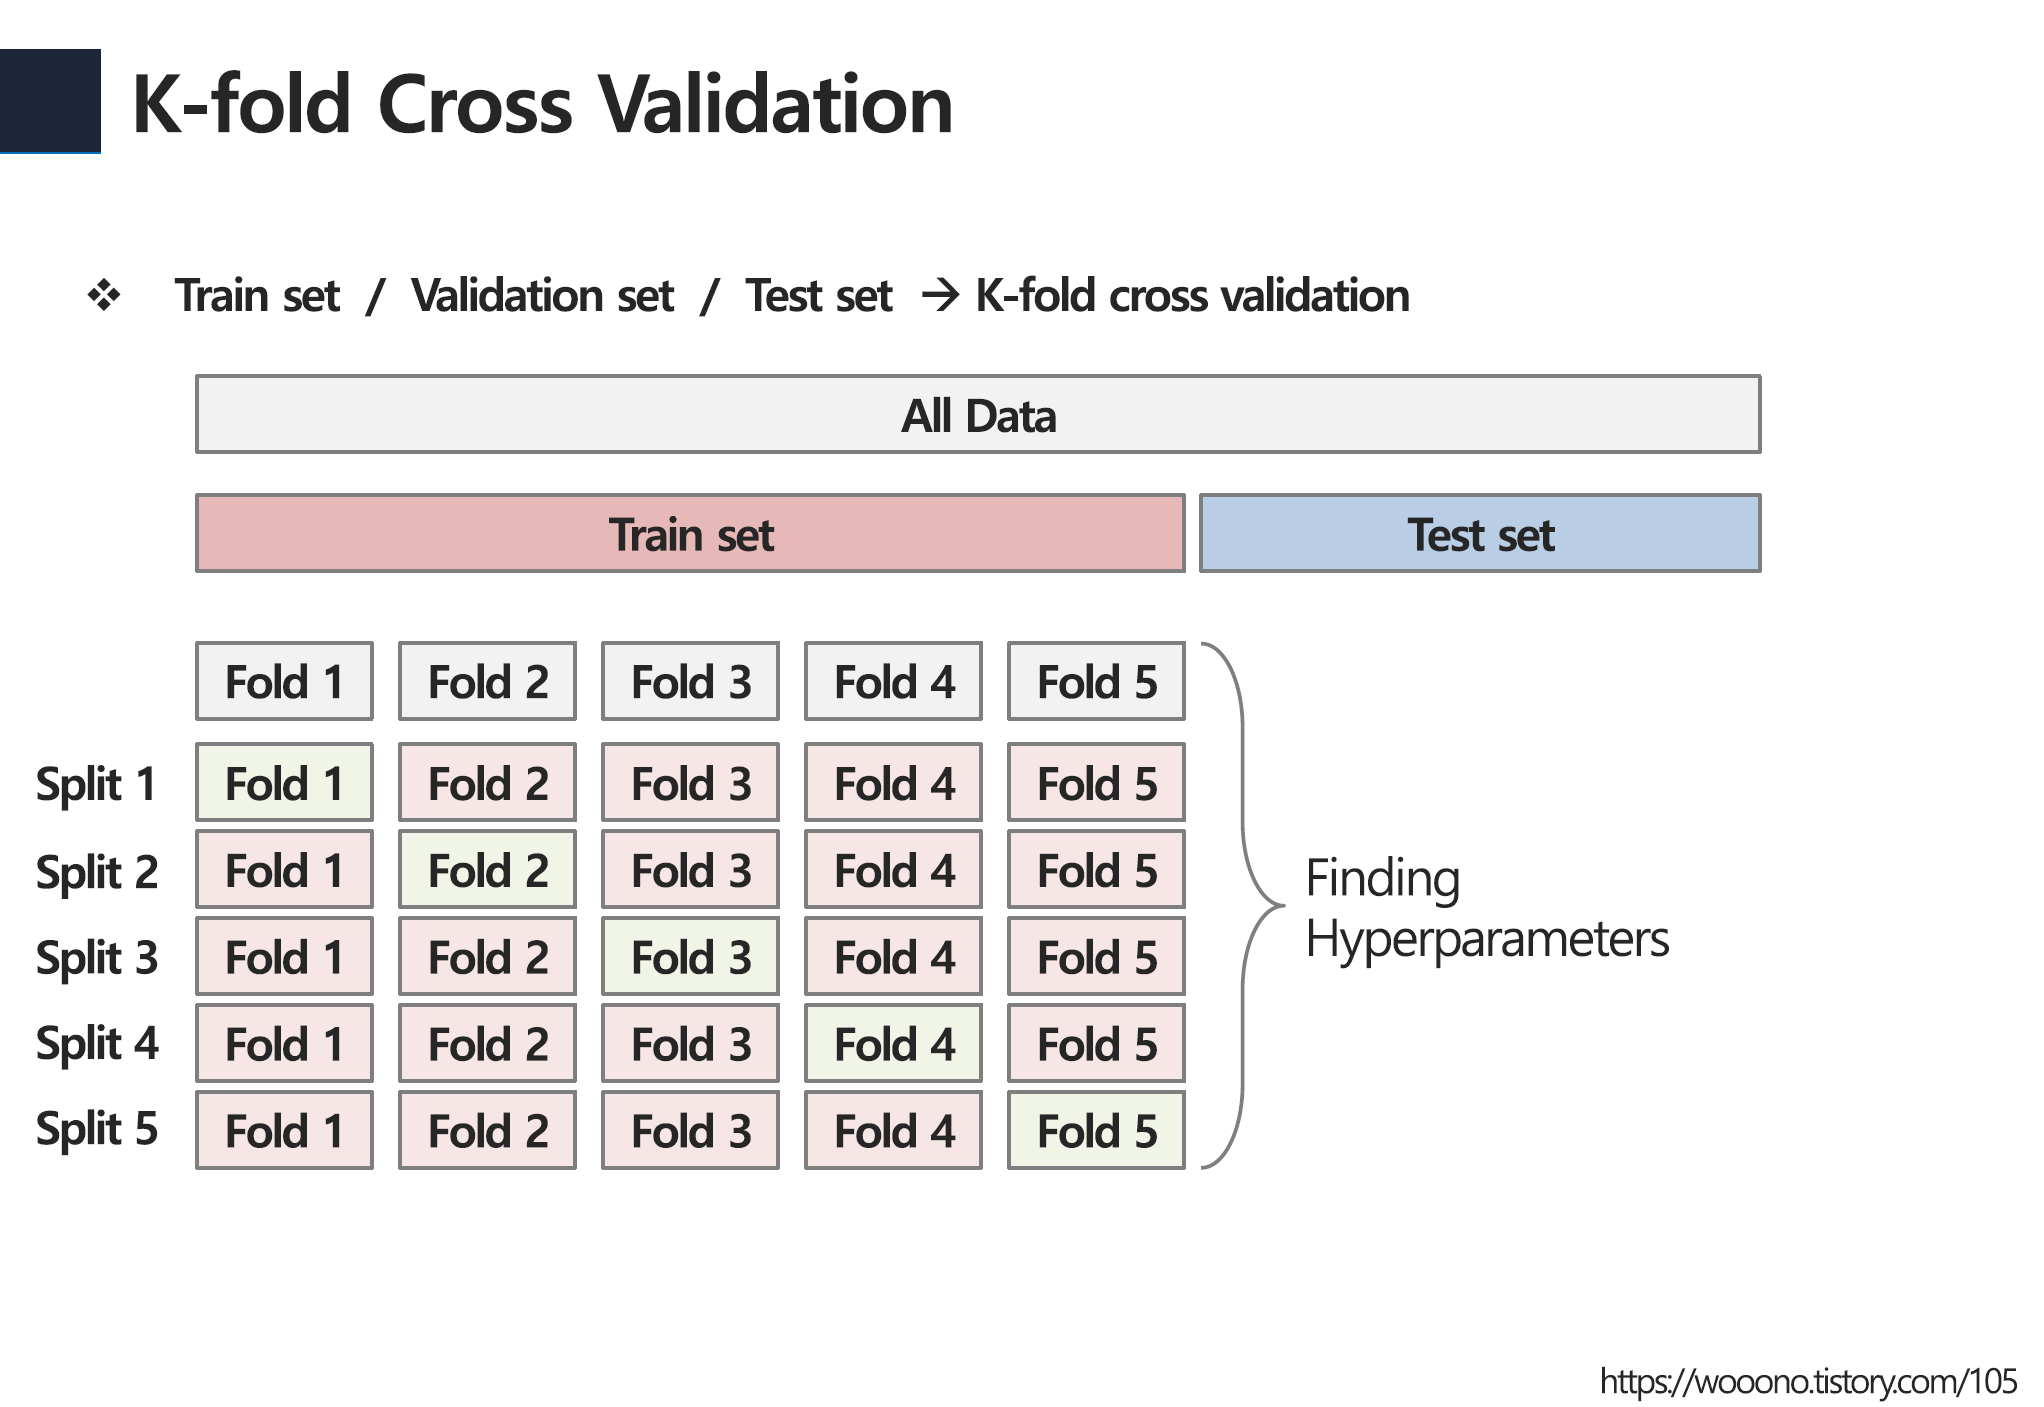

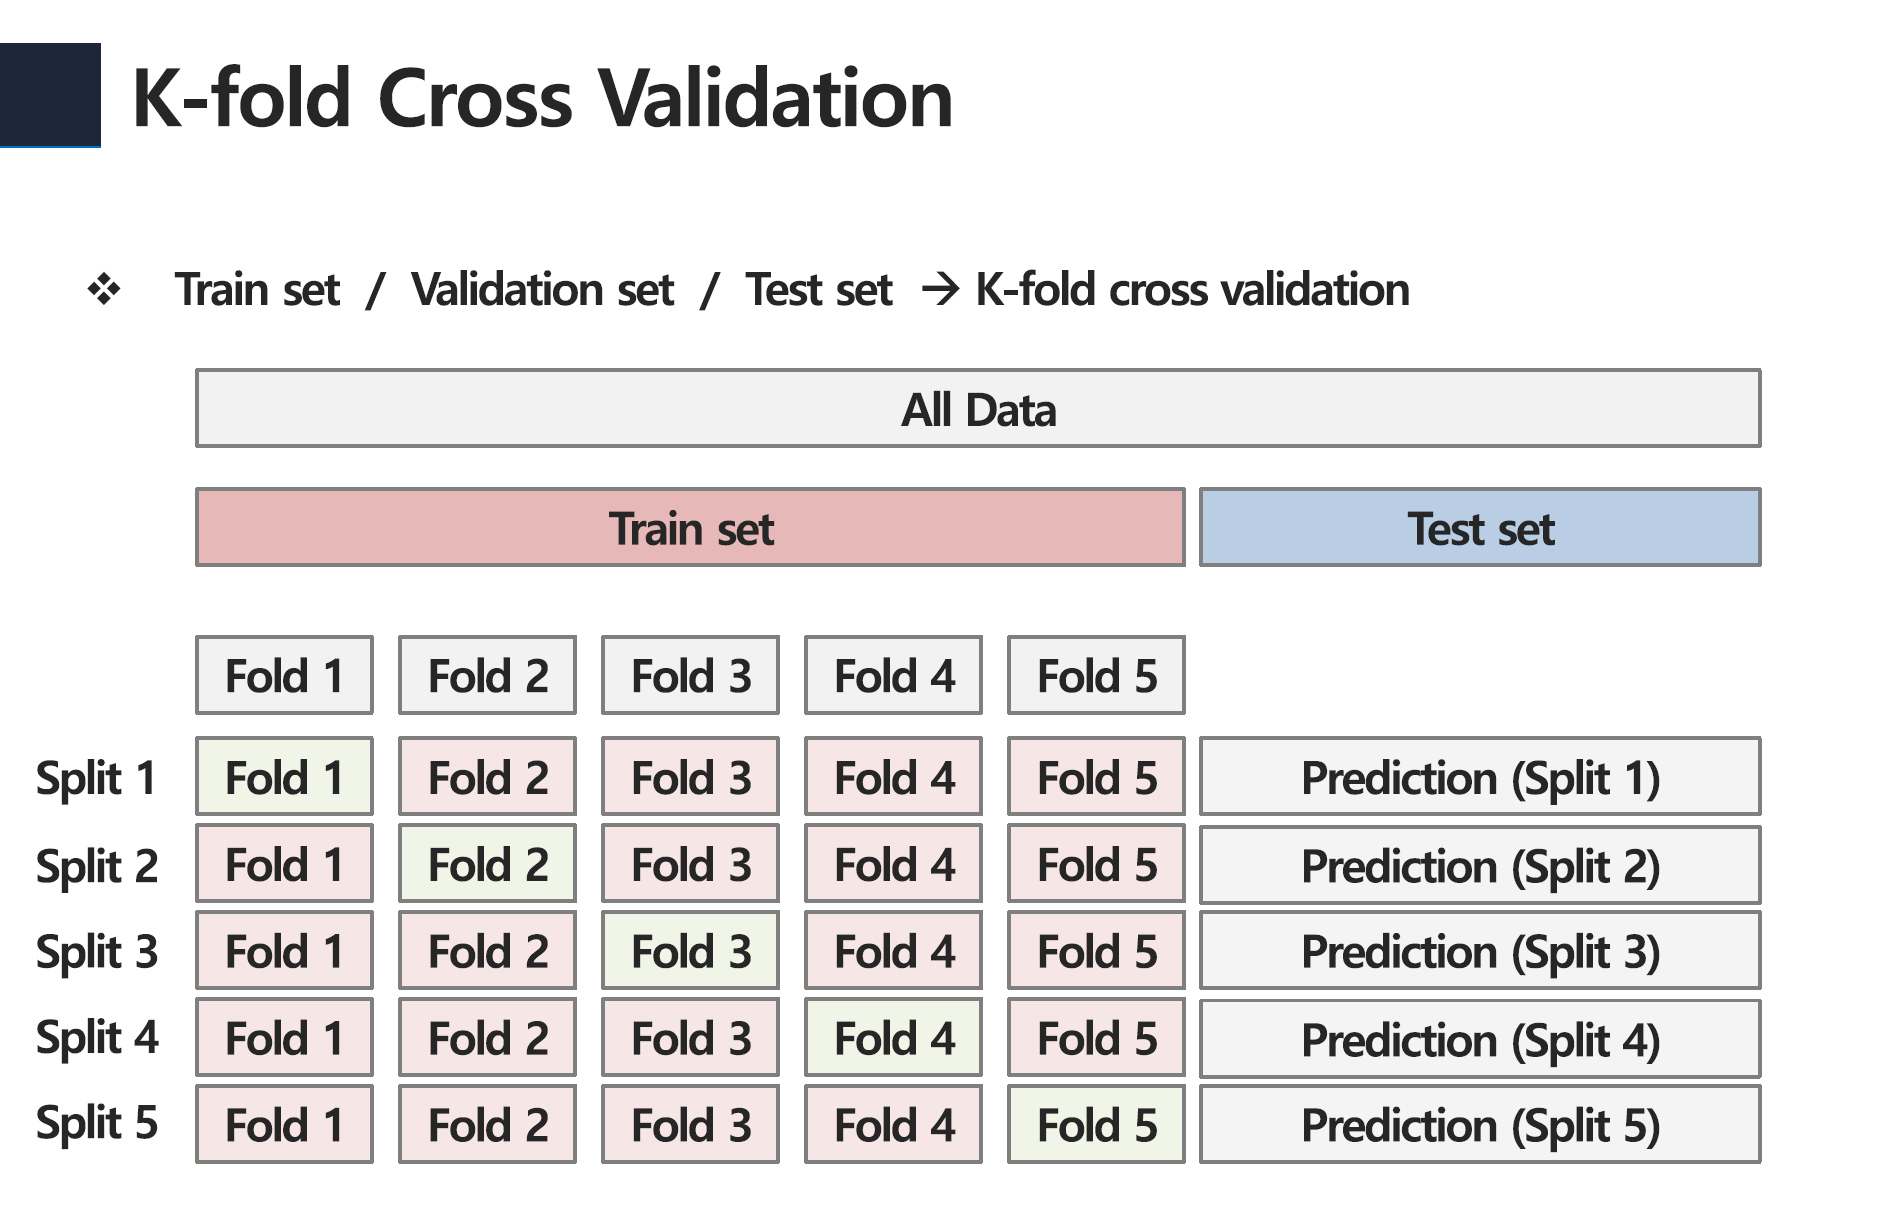

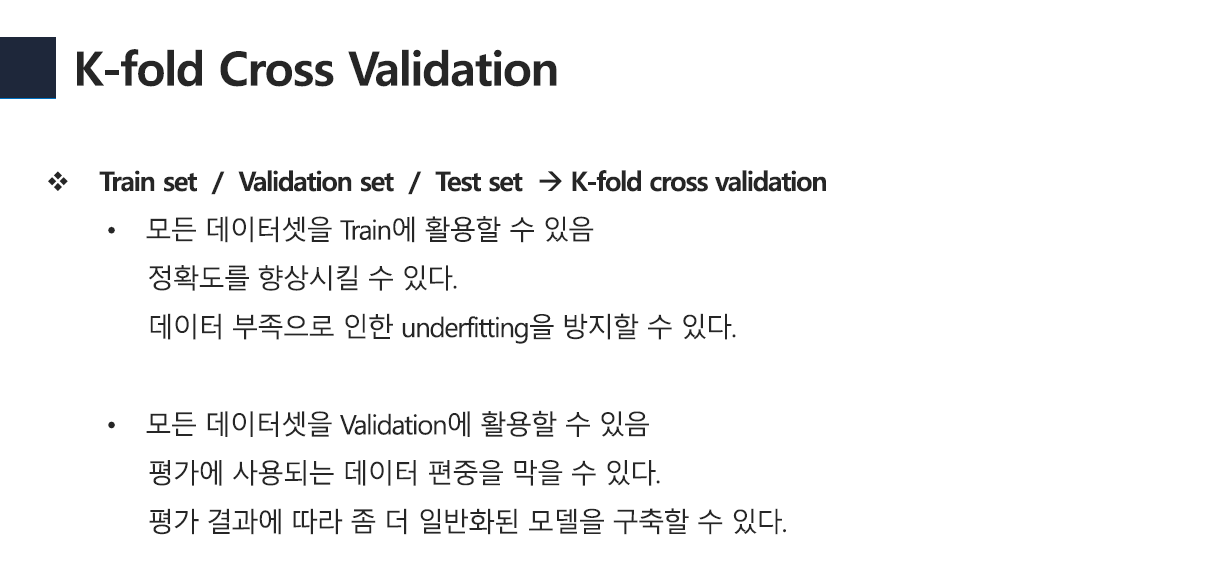

In [ ]:
cv = 5 # number of folds for cross validation
max_iter = 5000

n_trials = 50
def myrange(start, end, step):
    r = start
    while(r<end):
        yield r
        r += step
        
alpha_list = list(reversed([round(i,2) for i in myrange(0.01,10,0.1)]))

- 모델 학습

In [ ]:
model_Lasso = LassoCV(alphas=alpha_list, cv=cv, n_jobs=-1, random_state=1, max_iter=max_iter)
model_Lasso.fit(X_train, y_train)

In [ ]:
model_Lasso.alpha_

- 학습된 모델 사용 예측값 출력

In [ ]:
pred_train_LR = model_LR.predict(X_train)
pred_test_LR = model_LR.predict(X_test)
pred_train_Lasso = model_Lasso.predict(X_train)
pred_test_Lasso = model_Lasso.predict(X_test)

- 학습/테스트 예측 결과 성능 출력

In [ ]:
train_rmse_LR = np.sqrt(mean_squared_error(y_train, pred_train_LR))
train_mae_LR =  mean_absolute_error(y_train, pred_train_LR)
train_r2_LR = r2_score(y_train, pred_train_LR)

test_rmse_LR = np.sqrt(mean_squared_error(y_test, pred_test_LR))
test_mae_LR =  mean_absolute_error(y_test, pred_test_LR)
test_r2_LR = r2_score(y_test, pred_test_LR)

train_rmse_Lasso = np.sqrt(mean_squared_error(y_train, pred_train_Lasso))
train_mae_Lasso =  mean_absolute_error(y_train, pred_train_Lasso)
train_r2_Lasso = r2_score(y_train, pred_train_Lasso)

test_rmse_Lasso = np.sqrt(mean_squared_error(y_test, pred_test_Lasso))
test_mae_Lasso =  mean_absolute_error(y_test, pred_test_Lasso)
test_r2_Lasso = r2_score(y_test, pred_test_Lasso)

In [ ]:
results = pd.DataFrame(index=['rmse','mae','r2'],columns=['LR train','LR test','Lasso train','Lasso test'])

In [ ]:
results.loc['rmse','LR train']=train_rmse_LR
results.loc['mae','LR train']=train_mae_LR
results.loc['r2','LR train']=train_r2_LR

results.loc['rmse','LR test']=test_rmse_LR
results.loc['mae','LR test']=test_mae_LR
results.loc['r2','LR test']=test_r2_LR

results.loc['rmse','Lasso train']=train_rmse_Lasso
results.loc['mae','Lasso train']=train_mae_Lasso
results.loc['r2','Lasso train']=train_r2_Lasso

results.loc['rmse','Lasso test']=test_rmse_Lasso
results.loc['mae','Lasso test']=test_mae_Lasso
results.loc['r2','Lasso test']=test_r2_Lasso

- overfitting 막으면서 일반화 성능이 높아짐 확인

In [ ]:
results

### 3.3 k fold cross validation(K폴드 교차검증)으로 하이퍼 파라미터 찾기 + 모델 비교 선택

In [ ]:
# dict with optimal models
models = {} # dict()

# find optimal value of alpha 
n_trials = 20
alpha_list = 10 ** np.linspace(-3, 3, n_trials)

# number of folds for cross validation
cv = 5

# find optimal value of l1 (for ElasticNet)        
alpha_list = list(reversed([round(i,2) for i in myrange(0.01,10,0.1)]))
l1_list = list(reversed([round(i,2) for i in myrange(0,1,0.1)]))

max_iter = 5000

In [ ]:
# find optimal Lasso model
model = LassoCV(alphas=alpha_list, cv=cv, n_jobs=-1, random_state=1, max_iter=max_iter)
model.fit(X_train, y_train)
models['Lasso'] = Lasso(alpha=model.alpha_, max_iter=max_iter)

In [ ]:
# find optimal Ridge model
model = RidgeCV(alphas=alpha_list, cv=cv)
model.fit(X_train, y_train)
models['Ridge'] = Ridge(alpha=model.alpha_)

In [ ]:
# find optimal ElasticNet model
model = ElasticNetCV(alphas=alpha_list, l1_ratio=l1_list,
                   cv=cv, random_state=1, n_jobs=-1, max_iter=max_iter)
model.fit(X_train, y_train)
models['ElasticNet'] = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_, max_iter=max_iter)

In [ ]:
for name in models.keys():
    print(models[name])
    print('-'*100)

### 모델 비교 선택

In [ ]:
kf = KFold(cv, shuffle=True, random_state=1)
kf

In [ ]:
score = {}
for name in models.keys():
    # save score for each model
    if name not in score:
        score[name] = []

    # 모델
    reg = models[name]
    for i_train, i_valid in kf.split(X_train):
        # 학습
        reg.fit(X_train[i_train], y_train[i_train])
        # 예측
        y_pred = reg.predict(X_train[i_valid])
        RMSE = np.sqrt(mean_squared_error(y_train[i_valid], y_pred))
        score[name].append(RMSE)

In [ ]:
score

In [ ]:
results = pd.DataFrame(score)
results

In [ ]:
ax = results.plot.bar()
pd.concat([results.mean(), results.std()], axis=1, keys=['mean', 'std'])

### 3.4 최종 모델 학습, 결과 출력, 성능확인

In [ ]:
model = models['ElasticNet'].fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
print(f'train rmse : {rmse_train:.4f}')
print(f'test rmse : {rmse_test:.4f}')

In [ ]:
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print(f'train r2 : {r2_train:.4f}')
print(f'test r2 : {r2_test:.4f}')

#### 예측 결과 plotting

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('실제값 vs. 모델 출력값',fontsize=16)
plt.scatter(y_train, pred_train, c='red', alpha=0.5) # alpha 투명도 0일수록 투명
plt.scatter(y_test, pred_test, c='blue', alpha=0.5)
plt.plot(y_test,y_test, c='gray')
plt.plot(y_train,y_train, c='gray')
plt.xlabel('실제값', size=10)
plt.ylabel('모델 출력 값', size=10)
plt.show()

#### 계수값을 변수 중요도로 생각하기

In [ ]:
model = models['ElasticNet'].fit(X_train, y_train)

coef_df = pd.DataFrame(model.coef_.reshape(-1,1), index=X_test_final.columns, columns=['coefficients'])
coef_df.to_csv('coef.csv')
coef_df

In [ ]:
# Sort: descending order
coefficents = np.abs(coef_df.coefficients)
index = np.argsort(coefficents)[::-1]
print(index)

In [ ]:
importance =  coefficents[index]
columns = [list(coef_df.index)[i] for i in index]

In [ ]:
importance = importance[importance > 0]

In [ ]:
num_print = 20

plt.figure(figsize=(10,3))
plt.title('Feature Importances = ABS(coefficients)')
plt.bar(range(num_print),
        importance[:num_print],
        align='center')
plt.xticks(range(num_print), columns[:num_print], rotation=90, fontsize=11)
plt.show()

EOD